# Dependencies

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, load
import time
from scipy.interpolate import PchipInterpolator
import scipy
from collections import defaultdict
from tqdm import tqdm

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

from itertools import chain

# Data

In [2]:
df = pd.read_csv("../files/data/Corner_Crack_BH/CASE24_KI_Single_Cracks.csv", index_col=False)
df = df[df['a/t'] > 1]
df

,W/R,a/c,a/t,r/t,b/t,phi,K-T,K-B,K-P
91174,200.000,0.1,1.05,0.50,1.0,0.00007,7.277,4.725,8.599
91175,200.000,0.1,1.05,0.50,1.0,0.00014,7.465,4.847,8.820
91176,200.000,0.1,1.05,0.50,1.0,0.00020,7.599,4.934,8.979
91177,200.000,0.1,1.05,0.50,1.0,0.00027,7.691,4.993,9.087
91178,200.000,0.1,1.05,0.50,1.0,0.00034,7.751,5.032,9.158
...,...,...,...,...,...,...,...,...,...
4406286,133.333,10.0,10.00,0.75,1.0,0.10016,5.778,-4.673,96.010
4406287,133.333,10.0,10.00,0.75,1.0,0.10016,5.698,-4.610,94.680
4406288,133.333,10.0,10.00,0.75,1.0,0.10017,5.584,-4.518,92.780
4406289,133.333,10.0,10.00,0.75,1.0,0.10017,5.429,-4.393,90.190


In [3]:
# Get unique combinations of the first four columns
CC_combinations = df.iloc[:, :5].drop_duplicates().to_numpy()

print(len(CC_combinations))

5426


In [4]:
print("Different W/r values: ", np.unique(CC_combinations[:,0], axis=0))
print("Different a/c values: ", np.unique(CC_combinations[:,1], axis=0))
print("Different a/t values: ", np.unique(CC_combinations[:,2], axis=0))
print("Different r/t values: ", np.unique(CC_combinations[:,3], axis=0))
print("Different b/t values: ", np.unique(CC_combinations[:,4], axis=0))

Different W/r values:  [  10.      12.5     20.      25.      33.333   40.      50.      57.143
   75.019   80.     125.     133.333  175.009  200.     300.3    500.
  700.28   800.     900.901 1000.   ]
Different a/c values:  [ 0.1     0.111   0.125   0.1428  0.1667  0.2     0.25    0.333   0.5
  0.667   0.75    0.8     1.      1.25    1.333   1.5     2.      3.
  4.      5.      6.      7.      8.      9.     10.    ]
Different a/t values:  [ 1.05  1.15  1.25  1.5   1.75  2.    2.5   3.    4.    5.    6.    8.
 10.  ]
Different r/t values:  [ 0.1     0.111   0.125   0.1428  0.2     0.333   0.5     0.5714  0.75
  0.8     1.25    1.333   1.75    2.      2.5     3.      4.      5.
  8.     10.    ]
Different b/t values:  [1.]


In [15]:
d = df.to_numpy()

# Build a mapping from combination to indices
comb_to_indices = defaultdict(list)
for idx, row in enumerate(d):
    comb = tuple(row[:5])
    comb_to_indices[comb].append(idx)

# Convert lists to numpy arrays for faster indexing
for comb in comb_to_indices:
    comb_to_indices[comb] = np.array(comb_to_indices[comb])

In [18]:
d_final = np.zeros((len(CC_combinations)*128, 10))

num_removed = 0
for i, combination in tqdm(enumerate(CC_combinations)):
    data = np.zeros((128, 10))
    comb_tuple = tuple(combination)
    data[:,0] = i
    data[:,1:6] = comb_tuple

    indices = comb_to_indices.get(comb_tuple, np.array([]))
    if indices.size == 0:
        continue  # No data for this combination

    phi_vals = d[indices][:, -4]

    phi_min = phi_vals.min() + 0.035
    phi_max = phi_vals.max() - 0.035

    CC_phi_regular_128 = np.linspace(phi_min, phi_max, 132)
    data[:,-4] = CC_phi_regular_128[2:-2]


    # Filter indices where phi values lie within [phi_min, phi_max]
    filtered_indices = indices[(phi_vals >= phi_min) & (phi_vals <= phi_max)]

    phi_vals = d[filtered_indices][:,-4]
    if len(phi_vals) > 16:
        phi_idxes = np.argsort(phi_vals)
        monotonic_phi_idxes = [phi_idxes[0]]
        prev_phi = phi_vals[phi_idxes[0]]
        for index in phi_idxes[1:]:
            now_phi = phi_vals[index]
            if now_phi > prev_phi:
                monotonic_phi_idxes.append(index)
                prev_phi = phi_vals[index]

        # Tension
        K_vals = d[filtered_indices][:,-3]
        interp_func = PchipInterpolator(phi_vals[monotonic_phi_idxes], K_vals[monotonic_phi_idxes], extrapolate=False)
        data[:,-3] = interp_func(CC_phi_regular_128)[2:-2]

        # Bending
        K_vals = d[filtered_indices][:,-2]
        interp_func = PchipInterpolator(phi_vals[monotonic_phi_idxes], K_vals[monotonic_phi_idxes], extrapolate=False)
        data[:,-2] = interp_func(CC_phi_regular_128)[2:-2]

        # Bearing
        K_vals = d[filtered_indices][:,-1]
        interp_func = PchipInterpolator(phi_vals[monotonic_phi_idxes], K_vals[monotonic_phi_idxes], extrapolate=False)
        data[:,-1] = interp_func(CC_phi_regular_128)[2:-2]

        if np.isnan(data).any():
            num_removed += 1
            continue

        else:
            d_final[i*128:i*128+128] = data

    else:
        num_removed += 1
        continue


d_final = d_final[~np.all(d_final == 0, axis=1)]

output_df = pd.DataFrame(d_final, columns=["c_index", "W/R", "a/c", "a/t", "r/t", "b/t", "phi", "K-T", "K-B", "K-P"])

# Save the cleaned and processed DataFrame to a new CSV file
output_df.to_csv("../files/data/FINAL_CSV/CORNER_CRACK_BH_THROUGH_THICKNESS.csv", index=False)

print("Cracks removed: ", num_removed)

5426it [00:04, 1265.15it/s]


Cracks removed:  616


# Data Viz

In [19]:
df = pd.read_csv("../files/data/FINAL_CSV/CORNER_CRACK_BH_THROUGH_THICKNESS.csv")
df

,c_index,W/R,a/c,a/t,r/t,b/t,phi,K-T,K-B,K-P
0,0.0,200.000,0.1,1.05,0.50,1.0,0.053251,8.017986,5.083657,10.664907
1,0.0,200.000,0.1,1.05,0.50,1.0,0.062342,8.093528,5.107086,11.217668
2,0.0,200.000,0.1,1.05,0.50,1.0,0.071433,8.190579,5.142988,9.632060
3,0.0,200.000,0.1,1.05,0.50,1.0,0.080523,8.300711,5.185074,9.732275
4,0.0,200.000,0.1,1.05,0.50,1.0,0.089614,8.423436,5.232889,12.510558
...,...,...,...,...,...,...,...,...,...,...
615675,5423.0,133.333,10.0,6.00,0.75,1.0,0.127987,7.561296,-2.802499,173.566549
615676,5423.0,133.333,10.0,6.00,0.75,1.0,0.128731,7.559203,-2.849904,173.457928
615677,5423.0,133.333,10.0,6.00,0.75,1.0,0.129475,7.557050,-2.897324,173.341666
615678,5423.0,133.333,10.0,6.00,0.75,1.0,0.130219,7.554833,-2.944767,173.218730


Total cracks:  4810


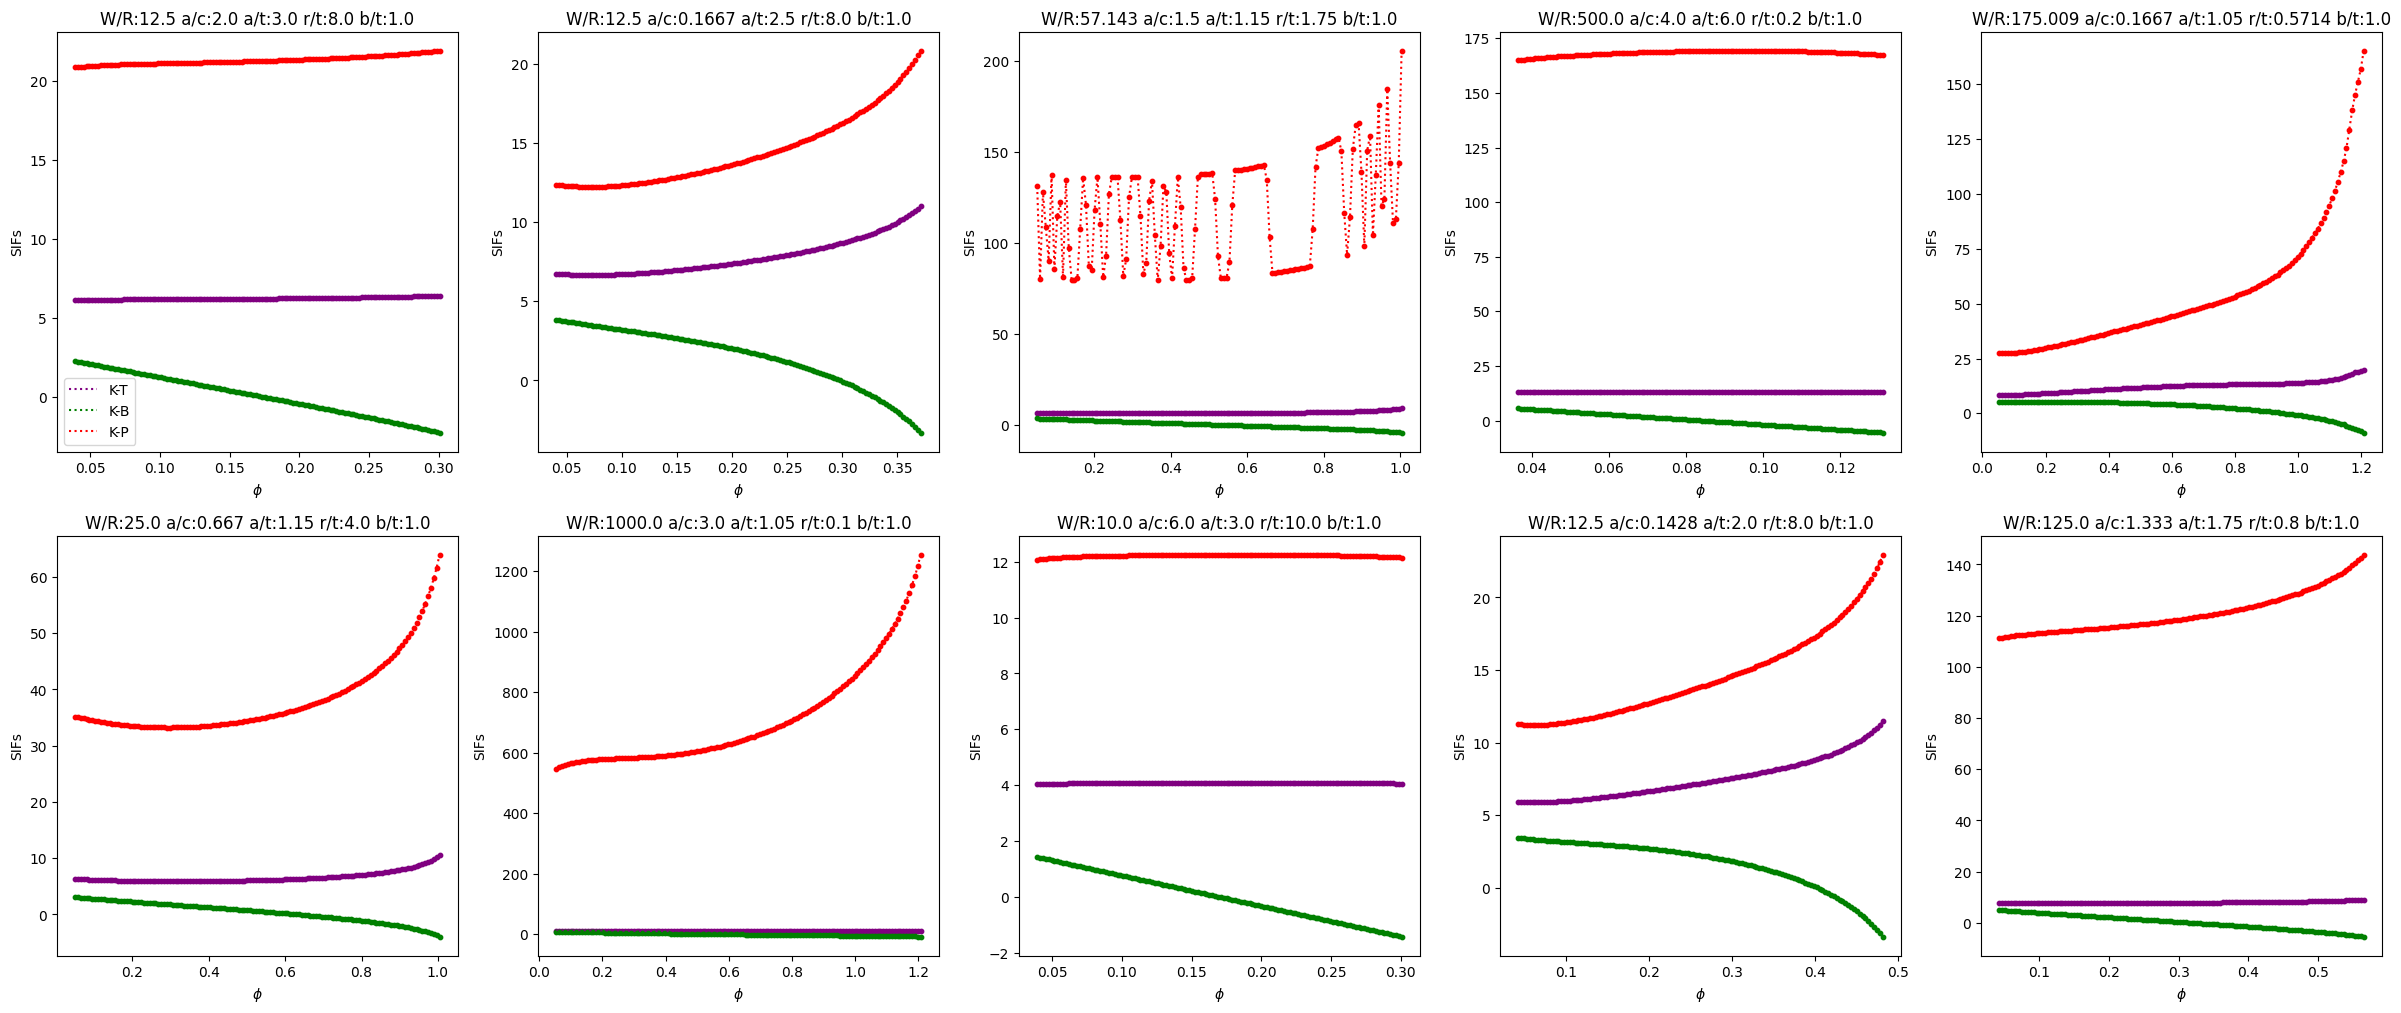

In [21]:
d = df.to_numpy()

num_crack = np.unique(d[:,0])

print("Total cracks: ", len(num_crack))

np.random.seed(0)
fig, axs = plt.subplots(2, 5, figsize=(30,12))
for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(num_crack))
        data = d[idx*128:idx*128+128]
        W_R = np.unique(data[:,1])
        a_c = np.unique(data[:,2])
        a_t = np.unique(data[:,3])
        r_t = np.unique(data[:,4])
        b_t = np.unique(data[:,5])

        assert len(W_R) == 1
        assert len(a_c) == 1
        assert len(a_t) == 1
        assert len(r_t) == 1
        assert len(b_t) == 1

        axs[i,j].scatter(data[:,-4], data[:,-3], color='purple', s=10)
        axs[i,j].plot(data[:,-4], data[:,-3], label="K-T", color='purple', linestyle=":")

        axs[i,j].scatter(data[:,-4], data[:,-2], color='green', s=10)
        axs[i,j].plot(data[:,-4], data[:,-2], label="K-B", color='green', linestyle=":")

        axs[i,j].scatter(data[:,-4], data[:,-1], color='red', s=10)
        axs[i,j].plot(data[:,-4], data[:,-1], label="K-P", color='red', linestyle=":")

        axs[i,j].set_title("W/R:{} a/c:{} a/t:{} r/t:{} b/t:{}".format(W_R[0], a_c[0], a_t[0], r_t[0], b_t[0]))
        axs[i,j].set_ylabel("SIFs")
        axs[i,j].set_xlabel(r"$\phi$")
        
        if i == 0 and j == 0:
            axs[i,j].legend()

plt.show()